In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from imageio.v2 import imread
from tqdm import trange
import matplotlib.pyplot as plt
import numpy as np
import torch
import scipy.ndimage
import tomosipo
import os
import tifffile
import astra

import autodiffCT.pipeline as cxpl
import autodiffCT.optimizer as ctxopt
import autodiffCT.tomography.reconstruction as recon

from autodiffCT.tomography.spectral import effective_spectrum, spectral_projection
from autodiffCT.image.segmentation import ThresholdOperator, SegmentationMaskOperator, apply_thresholds, soft_thresholds
from autodiffCT.tomography.project import AutogradedTomosipoOperator
from autodiffCT.tomography.reconstruction import fbp

from autodiffCT.ISP import ISP, global_gradient_method


def plot_imgs(height=6, cmap="gray", clim=(None, None), **kwargs):
    fig, axes = plt.subplots(
        nrows=1,
        ncols=len(kwargs),
        figsize=(height * len(kwargs), height)
    )
    fig.patch.set_alpha(1.0)
    if len(kwargs) == 1:
        axes = [axes]
    it = 0
    for ax, (k, v) in zip(axes, kwargs.items()):
        if isinstance(v, torch.Tensor):
            v = v.cpu().numpy()
        if isinstance(clim, list):
            pcm = ax.imshow(v.squeeze(), cmap=cmap, clim=clim[it])
        else:
            pcm = ax.imshow(v.squeeze(), cmap=cmap, clim=clim)
        fig.colorbar(pcm, ax=ax)
        ax.set_title(k)
        it += 1
    fig.tight_layout()
    plt.show()

PMMA_DENSITY = 1.18
PMMA_FORMULA = 'C5O2H8'
AL_DENSITY = 2.7

/export/scratch2/schoonho/anaconda3/envs/pipeline_python310/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Get date to date the saves:
from datetime import datetime
import os

date_str = datetime.today().strftime('0%Y-%m-%d')
path = 'experimental_results/'+date_str +'/'

# Make directory if it does not exist
folder = os.path.dirname(path)
if not os.path.exists(folder):
    os.makedirs(folder)

In [4]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
    
phantom = np.load('barbapapa_phantom.npz')['phantom']

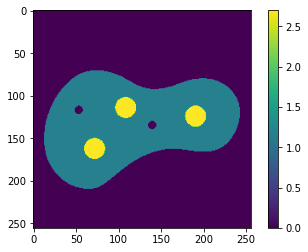

In [5]:
pmma = torch.tensor(PMMA_DENSITY * (phantom == 1), dtype=torch.float32)
al = torch.tensor(AL_DENSITY * (phantom == 2), dtype=torch.float32)
plt.imshow(pmma + al)
plt.colorbar()
plt.savefig(path + 'barbabapa_phantom.pdf')
plt.show()
torch.save(pmma+al, path + 'barbapapa_phantom.torch')

In [ ]:
energies = torch.linspace(5, 60, 128)
spectrum = effective_spectrum(energies, acceleration_voltage=60.0)

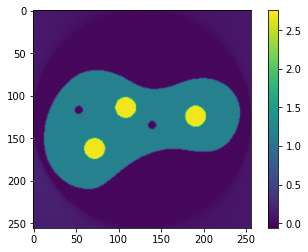

In [8]:
# The phantom is about 3 cm long (looking at the pictures in the paper)
vol_geom = tomosipo.volume(shape=[1, *phantom.shape], size=3)
proj_geom = tomosipo.parallel(angles=360, shape=[1, max(phantom.shape)], size=3)
A = tomosipo.operator(vol_geom, proj_geom)
projs = A((pmma + al).unsqueeze(dim=0))

rec = fbp(A, projs, padded=True)
plt.imshow(rec.squeeze())
plt.colorbar()

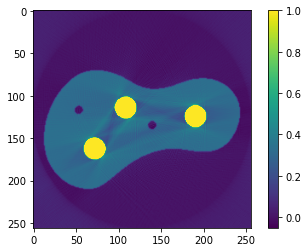

In [10]:
spectral_projs = spectral_projection(A, energies, spectrum,
                                     [pmma.unsqueeze(dim=0), al.unsqueeze(dim=0)],
                                     [PMMA_FORMULA, 'Al'])
rec_spectral = fbp(A, spectral_projs, padded=True)
plt.imshow(rec_spectral.squeeze(), vmax=1.0)
plt.colorbar()
plt.savefig(path + "barbapapa_rec_spectral.pdf")

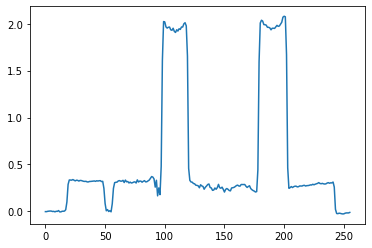

In [11]:
plt.plot(rec_spectral[0, 120, :])
plt.savefig(path + 'barbapapa_rec_spectral_cupping.pdf')

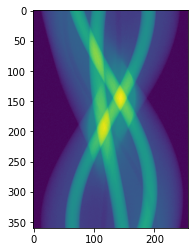

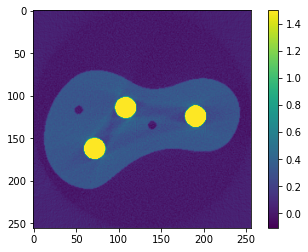

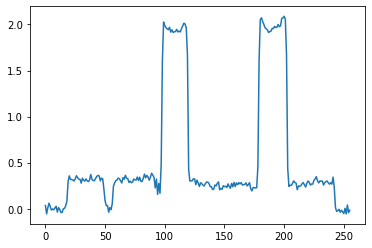

In [13]:
# Add Gaussian noise
noisy_spectral_projs = spectral_projs.clone().to(device)
noise_percent = 2
noisy_spectral_projs += .01 * noise_percent * spectral_projs.mean() * torch.randn(*spectral_projs.shape, device=device)
rec_noisy = fbp(A, noisy_spectral_projs, padded=True).squeeze(0)
torch.save(noisy_spectral_projs, path + 'barbapap_noisy_spectral_projs.torch')
plt.imshow(noisy_spectral_projs[0].cpu().detach())
plt.show()
plt.imshow(rec_noisy.squeeze().cpu().detach(), vmax=1.5)
plt.colorbar()
torch.save(rec_noisy, path + 'barbapap_rec_noisy.torch')
plt.savefig(path + "barbapapa_rec_noisy.pdf")
plt.show()
plt.plot(rec_noisy[120, :].cpu().detach().numpy())
plt.savefig(path + 'barbapapa_rec_noisy_cupping.pdf')

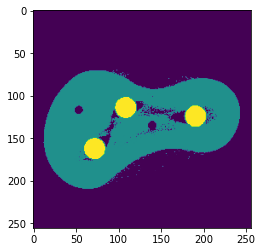

In [23]:
with torch.no_grad():
        segm_op = ThresholdOperator(n_classes=3, bins=128, device=device, gamma=100.0,
                                re_init_at_call=True, split_classes=False)
        segm_noisy = segm_op(rec_noisy)
        plt.imshow(segm_noisy.cpu().detach())
        plt.show()
        torch.save(segm_noisy, path + 'segm_noisy_barbapapa.torch')

# Implement ISP method
(https://www.researchgate.net/publication/221699198Iterative Correction of beam hardening artifacts in CT)

In [15]:
# The paper specifies that air must be included, so air, PMMA, Al is N=3
N = 3
E_m = 3 # Number of bins
energies = torch.linspace(5, 60, E_m, device=device)
spectrum = torch.ones(size=(E_m,), device=device) / E_m

# Make autogradable projector
A_diff = AutogradedTomosipoOperator(A)

In [30]:
losses = []
corrected_y, spectrum_c, attenuations_c, thresholds_c = ISP(noisy_spectral_projs.clone().to(device),
                                              A_diff,
                                              N,
                                              energies,
                                              spectrum.clone(),
                                              steps=40,
                                              losses=losses,
                                              thr_bins=64,
                                              lmin_steps=1000,
                                              lrs=[2*1e-1, 2*1e-1])#Takes 16 minutes (16 min, 15 seconds to be exact)

  0%|          | 0/40 [00:00<?, ?it/s]/export/scratch2/schoonho/anaconda3/envs/pipeline_python310/lib/python3.10/site-packages/tomosipo/links/torch.py:55: UserWarning: The parameter initial_value is of type torch.int32; expected `torch.float32`. The type has been automatically converted. Use `ts.link(x.to(dtype=torch.float32))' to inhibit this warning. 
  warnings.warn(
100%|██████████| 40/40 [16:15<00:00, 24.38s/it]


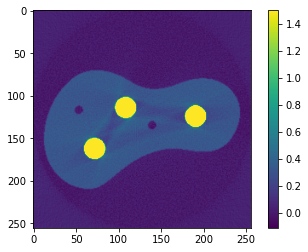

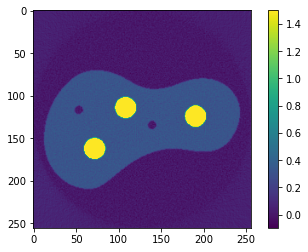

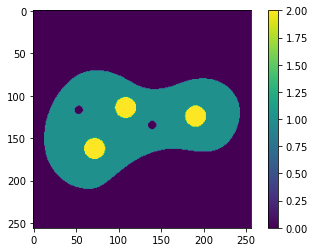

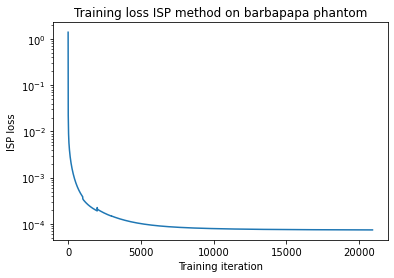

In [31]:
rec_corrected_ISP = fbp(A, corrected_y, padded=True).squeeze(0)
segm_corrected_ISP = apply_thresholds(rec_corrected_ISP, thresholds_c)

torch.save(rec_corrected_ISP, path + 'rec_corrected_ISP_barbapapa.torch')
torch.save(corrected_y, path + 'corrected_y_ISP_barbapapa.torch')
torch.save(segm_corrected_ISP, path + 'segm_corrected_ISP_barbapapa.torch')

plt.imshow(rec_noisy.squeeze().cpu().detach(), vmax=1.5)
plt.colorbar()
plt.show()
plt.imshow(rec_corrected_ISP.cpu().squeeze(), vmax=1.5)
plt.colorbar()
plt.show()
plt.imshow(segm_corrected_ISP.cpu().detach().squeeze())
plt.colorbar()
plt.show()
plt.semilogy(losses)
plt.title("Training loss ISP method on barbapapa phantom")
plt.xlabel("Training iteration")
plt.ylabel("ISP loss")
plt.savefig(path + "ISP_training_loss_barbapapa.pdf")
plt.show()
torch.save(torch.tensor(losses), path + "ISP_losses_barbapapa.torch")

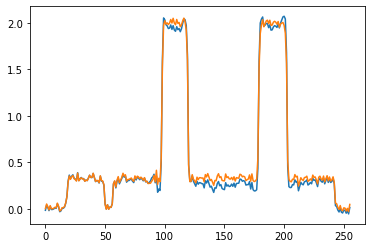

In [32]:
plt.plot(rec_noisy[120, :].cpu().detach())
plt.plot(rec_corrected_ISP[120, :].cpu().detach())

## Global gradient method end-to-end

In [61]:
# The paper specifies that air must be included, so air, PMMA, Al is N=3
N = 3
E_m = 3 # Number of bins
energies = torch.linspace(5, 60, E_m, device=device)
spectrum = torch.ones(size=(E_m,), device=device) / E_m

In [62]:
steps = 400
losses_glob = []
corr_y_glob, spectrum_glob, atten_glob, thresholds_glob = global_gradient_method(noisy_spectral_projs.clone().to(device),
                                                                          A_diff,
                                                                          N,
                                                                          energies,
                                                                          spectrum.clone(),
                                                                          steps=steps,
                                                                          losses=losses_glob,
                                                                          local_min_steps=50,
                                                                          lrs=[6*1e-1, 6*1e-1, 4*1e-1])

  0%|          | 0/400 [00:00<?, ?it/s]/export/scratch2/schoonho/anaconda3/envs/pipeline_python310/lib/python3.10/site-packages/tomosipo/links/torch.py:55: UserWarning: The parameter initial_value is of type torch.int32; expected `torch.float32`. The type has been automatically converted. Use `ts.link(x.to(dtype=torch.float32))' to inhibit this warning. 
  warnings.warn(
 85%|████████▌ | 340/400 [07:31<01:18,  1.31s/it]

Stopped at iteration: 36


 85%|████████▌ | 341/400 [07:32<01:09,  1.18s/it]

Stopped at iteration: 29


 86%|████████▋ | 346/400 [07:39<01:08,  1.27s/it]

Stopped at iteration: 37


 87%|████████▋ | 348/400 [07:40<00:47,  1.10it/s]

Stopped at iteration: 5


 88%|████████▊ | 350/400 [07:42<00:48,  1.04it/s]

Stopped at iteration: 27


 88%|████████▊ | 351/400 [07:43<00:47,  1.03it/s]

Stopped at iteration: 35


 88%|████████▊ | 354/400 [07:46<00:45,  1.02it/s]

Stopped at iteration: 18


 89%|████████▉ | 356/400 [07:47<00:32,  1.37it/s]

Stopped at iteration: 33
Stopped at iteration: 4


 90%|████████▉ | 359/400 [07:51<00:40,  1.02it/s]

Stopped at iteration: 27


 90%|█████████ | 360/400 [07:52<00:43,  1.08s/it]

Stopped at iteration: 45


 90%|█████████ | 361/400 [07:53<00:33,  1.17it/s]

Stopped at iteration: 11


 91%|█████████ | 363/400 [07:54<00:29,  1.26it/s]

Stopped at iteration: 12


 91%|█████████ | 364/400 [07:55<00:31,  1.15it/s]

Stopped at iteration: 41
Stopped at iteration: 1


 92%|█████████▏| 366/400 [07:56<00:18,  1.80it/s]

Stopped at iteration: 10


 92%|█████████▏| 367/400 [07:56<00:20,  1.59it/s]

Stopped at iteration: 31


 92%|█████████▏| 368/400 [07:57<00:19,  1.64it/s]

Stopped at iteration: 19


 92%|█████████▏| 369/400 [07:57<00:16,  1.85it/s]

Stopped at iteration: 11


 92%|█████████▎| 370/400 [07:58<00:20,  1.44it/s]

Stopped at iteration: 38


 93%|█████████▎| 372/400 [08:00<00:18,  1.48it/s]

Stopped at iteration: 3


 94%|█████████▎| 374/400 [08:02<00:17,  1.52it/s]

Stopped at iteration: 2


 94%|█████████▍| 375/400 [08:03<00:20,  1.20it/s]

Stopped at iteration: 44


 94%|█████████▍| 376/400 [08:03<00:16,  1.42it/s]

Stopped at iteration: 16


 94%|█████████▍| 378/400 [08:04<00:12,  1.78it/s]

Stopped at iteration: 36
Stopped at iteration: 5


 95%|█████████▌| 380/400 [08:05<00:08,  2.48it/s]

Stopped at iteration: 14
Stopped at iteration: 7


 95%|█████████▌| 381/400 [08:05<00:06,  2.90it/s]

Stopped at iteration: 8


 96%|█████████▌| 382/400 [08:05<00:05,  3.15it/s]

Stopped at iteration: 10


 96%|█████████▌| 384/400 [08:06<00:04,  3.49it/s]

Stopped at iteration: 19
Stopped at iteration: 3


 96%|█████████▋| 385/400 [08:06<00:04,  3.37it/s]

Stopped at iteration: 12
Stopped at iteration: 1


 97%|█████████▋| 387/400 [08:06<00:03,  3.97it/s]

Stopped at iteration: 14


 97%|█████████▋| 388/400 [08:07<00:03,  3.33it/s]

Stopped at iteration: 19
Stopped at iteration: 2


 98%|█████████▊| 391/400 [08:07<00:01,  4.63it/s]

Stopped at iteration: 10
Stopped at iteration: 4


 98%|█████████▊| 394/400 [08:08<00:01,  5.81it/s]

Stopped at iteration: 14
Stopped at iteration: 2
Stopped at iteration: 1


 99%|█████████▉| 396/400 [08:08<00:00,  6.54it/s]

Stopped at iteration: 3
Stopped at iteration: 5


100%|█████████▉| 398/400 [08:09<00:00,  5.16it/s]

Stopped at iteration: 14
Stopped at iteration: 6


100%|██████████| 400/400 [08:09<00:00,  1.22s/it]

Stopped at iteration: 11
Stopped at iteration: 4


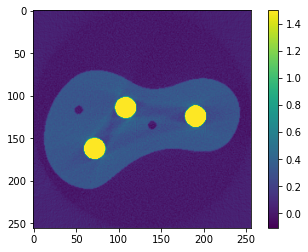

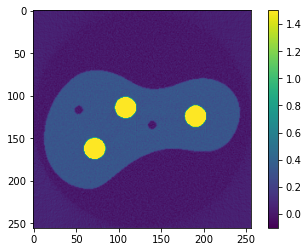

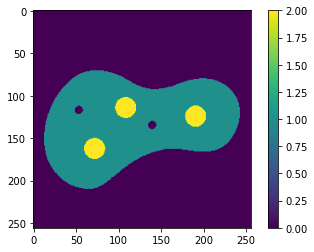

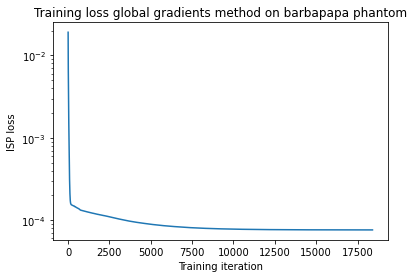

In [63]:
rec_corr_glob = fbp(A, corr_y_glob, padded=True).squeeze(0)
segm_corr_glob = soft_thresholds(rec_corr_glob, thresholds_glob, gamma=100.0, device=device)

id = 'localminsteps=50_steps=400'

torch.save(rec_corr_glob, path + 'rec_corrected_GlobalGradients_barbapapa_'+id+'.torch')
torch.save(corr_y_glob, path + 'corrected_y_GlobalGradients_barbapapa_'+id+'.torch')
torch.save(segm_corr_glob, path + 'segm_corrected_GlobalGradients_barbapapa_'+id+'.torch')

plt.imshow(rec_noisy.squeeze().cpu().detach(), vmax=1.5)
plt.colorbar()
plt.show()
plt.imshow(rec_corr_glob.cpu().squeeze(), vmax=1.5)
plt.colorbar()
plt.show()
plt.imshow(segm_corr_glob.cpu().detach().squeeze())
plt.colorbar()
plt.show()
plt.semilogy(losses_glob)
plt.title("Training loss global gradients method on barbapapa phantom")
plt.xlabel("Training iteration")
plt.ylabel("ISP loss")
plt.savefig(path + 'BH_GlobalGradients_training_loss_barbapapa_'+id+'.pdf')
plt.show()
torch.save(torch.tensor(losses_glob), path + "GlobalGradients_losses_barbapapa.torch")